In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 29 21:39:37 2023

@author: Bebesi Laci
"""

import sys
import os
import re
import pandas as pd
import numpy as np
import yfinance as yf
import logging
import sqlite3
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
sys.path.insert(0, r"K:/Thesis/codes/crypto_project")
sys.path.insert(0, r"E:/Thesis/crypto_project")

from factor_model.offline_elements.loaders.price_data_loaders import (
    generate_ytickets,
    generate_price_data_map
)
from factor_model.offline_elements.loaders.market_cap_loader import (
    generate_market_cap_data, generate_market_cap_only
)
from factor_model.offline_elements.loaders.crypto_coin_loaders import (
    get_ticker_list
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

from factor_model.offline_elements.return_generators.total_return_calculation import generate_return_data
from datetime import date, timedelta
from factor_model.offline_elements.database_generators.generate_databases import refresh_raw_price_database
from factor_model.offline_elements.estimation_universe.estimation_core_universe import generate_estimation_basis
from factor_model.offline_elements.styles.return_based import generate_x_month_price_change
from factor_model.offline_elements.styles.volume_based import generate_x_month_aggregate_volume
from factor_model.offline_elements.factor_return_estimation.factor_return_estimation import create_factor_return_data
# from analysis.tickers import ticker_list
# from analysis.utility import convert_str_numbs_to_float
# from analysis.styles.return_based import generate_x_month_momentum
# from analysis.market_cap import generate_market_cap_data
# from analysis.ticker_basics import generate_ytickets, generate_price_data_map
# from analysis.returns import generate_return_data
# from analysis.estimation_basis import generate_estimation_basis
# from datetime import date, timedelta
# import matplotlib.pyplot as plt
# import datetime
# import statsmodels.api as sm
# from analysis.factor_return_dataset import create_factor_return_data, create_expo_from_daily_data
# from tqdm import tqdm
# import matplotlib.pyplot as plt

DATABASE_LOCATION = r"E:/Thesis/database"
RAW_DATA_DB = "raw_price_data.db"

In [2]:

parameters = {
    "HORIZON" : "20y",
    "ESTIMATION_HORIZON": int(6.5*365),
    "WEIGHT_FUNCTION" : np.sqrt,
    "PRESENT_IN_MARKET" : 3*365,  # trade days, 3 years approx
    "ESTIMATION_DAY": date.today(),
    "MARKET_CAP_COVERAGE" : 0.82,
    "NEW_COIN_INCLUSION": 120,  # after X days
    "REGRESSORS_SET1": ["market", "size", "momentum", "reversal", "volume"],
    "REGRESSORS_SET2": ["new_coin"],
    "MONTH_LENGTH": 30
}
parameters["CORE_UNIV_START"] = parameters["ESTIMATION_DAY"] - timedelta(parameters["PRESENT_IN_MARKET"])


In [3]:
tickers = get_ticker_list()


In [4]:
yfinance_tickers = generate_ytickets(tickers)
price_data_map = generate_price_data_map(yfinance_tickers, parameters["HORIZON"])

# refresh tickers and throw out those ones, which have no price history
drop_keys = list()
for key in price_data_map.keys():
    if len(price_data_map[key]) < 2:  # minimum number of obs for returns are 2
        del yfinance_tickers[key]
        drop_keys.append(key)
for key in drop_keys:
    del price_data_map[key]


In [5]:
price_data_map["1000SATS-USD"]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
0,0.000620,0.000620,0.000449,0.000552,463757729,0.0,0.0,2023-12-12
1,0.000553,0.000553,0.000462,0.000512,227324440,0.0,0.0,2023-12-13
2,0.000512,0.000793,0.000509,0.000758,678539767,0.0,0.0,2023-12-14
3,0.000757,0.000928,0.000710,0.000733,878538869,0.0,0.0,2023-12-15
4,0.000734,0.000875,0.000678,0.000777,378662135,0.0,0.0,2023-12-16
...,...,...,...,...,...,...,...,...
76,0.000478,0.000509,0.000457,0.000498,44756809,0.0,0.0,2024-02-26
77,0.000498,0.000523,0.000490,0.000511,67415316,0.0,0.0,2024-02-27
78,0.000511,0.000596,0.000497,0.000542,198220965,0.0,0.0,2024-02-28
79,0.000541,0.000600,0.000504,0.000520,138153299,0.0,0.0,2024-02-29


In [18]:
yfinance_tickers.keys()

dict_keys(['1000SATS-USD', '1INCH-USD', 'AAVE-USD', 'ACE28674-USD', 'ADA-USD', 'AGIX-USD', 'AIOZ-USD', 'AKT-USD', 'ALEX-USD', 'ALGO-USD', 'ALPH-USD', 'ANKR-USD', 'ANT-USD', 'APE18876-USD', 'API3-USD', 'APT21794-USD', 'AR-USD', 'ARB11841-USD', 'ARKM-USD', 'ASTR-USD', 'ATOM-USD', 'AUDIO-USD', 'AVAX-USD', 'AXL17799-USD', 'AXS-USD', 'AZERO-USD', 'BAL-USD', 'BAND-USD', 'BAT-USD', 'BCH-USD', 'BDX-USD', 'BEAM28298-USD', 'BGB-USD', 'BICO-USD', 'BLUR-USD', 'BNB-USD', 'BONK-USD', 'BSV-USD', 'BTC-USD', 'BTCB-USD', 'BTG-USD', 'BTT-USD', 'BUSD-USD', 'C98-USD', 'CAKE-USD', 'CBETH-USD', 'CELO-USD', 'CFG-USD', 'CFX-USD', 'CHEEL-USD', 'CHR-USD', 'CHZ-USD', 'CKB-USD', 'COMP5692-USD', 'CORE23254-USD', 'COTI-USD', 'CRO-USD', 'CRV-USD', 'CSPR-USD', 'CTSI-USD', 'CVX-USD', 'DAI-USD', 'DASH-USD', 'DCR-USD', 'DESO-USD', 'DOGE-USD', 'DOT-USD', 'EDU24613-USD', 'EGLD-USD', 'ELF-USD', 'ENJ-USD', 'ENS-USD', 'EOS-USD', 'ERC20-USD', 'ETC-USD', 'ETH-USD', 'ETHDYDX-USD', 'ETHW-USD', 'FDUSD-USD', 'FET-USD', 'FIL-USD', '

In [20]:
try:
    market_cap_df = generate_market_cap_only(yfinance_tickers)
except Exception:
    market_cap_df = generate_market_cap_data(yfinance_tickers)


HTTPError: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v6/finance/quoteSummary/1000SATS-USD?modules=financialData&modules=quoteType&modules=defaultKeyStatistics&modules=assetProfile&modules=summaryDetail&ssl=true

In [21]:
market_cap_df = generate_market_cap_data(yfinance_tickers)


In [23]:
return_data_map = generate_return_data(price_data_map)
estimation_dates=list(return_data_map["BTC-USD"].tail(parameters["ESTIMATION_HORIZON"])["date"])

E:\Thesis/crypto_project\factor_model\offline_elements\return_generators\total_return_calculation.py:9: RuntimeWarning: divide by zero encountered in true_divide
  gg = np.matrix(price_data_map[key]["Close"].diff().tail(-1)) / np.matrix(
E:\Thesis/crypto_project\factor_model\offline_elements\return_generators\total_return_calculation.py:9: RuntimeWarning: invalid value encountered in true_divide
  gg = np.matrix(price_data_map[key]["Close"].diff().tail(-1)) / np.matrix(


In [24]:
estimation_dates = list(
    return_data_map["ETC-USD"].tail(parameters["ESTIMATION_HORIZON"])["date"]
)
estimation_dates = [
    date_value
    for date_value in estimation_dates
    if date_value > datetime.date(2018, 5, 8)
]  # six months after ETH-USD has data in yfinance


In [25]:
# weighting generation and universe
market_cap_df["transformed_market_cap"] = parameters["WEIGHT_FUNCTION"](market_cap_df["market_cap"])
market_cap_df.sort_values(by = "transformed_market_cap", ascending=False, inplace=True)

# 0. market cap date 
market_cap_date = parameters["ESTIMATION_DAY"]
estimation_basis_last, univ_first_appearence = generate_estimation_basis(return_data_map, market_cap_df, market_cap_date, parameters)

#### Style generation

In [26]:
momentum_move_map = generate_x_month_price_change(price_data_map,  x_len = 6, month_len = parameters["MONTH_LENGTH"])
reversal_map = generate_x_month_price_change(price_data_map,  x_len = 1, month_len = parameters["MONTH_LENGTH"])
volume_map = generate_x_month_aggregate_volume(price_data_map,  x_len = 1, month_len = parameters["MONTH_LENGTH"])
daily_data_maps = {}
daily_data_maps["reversal"] = reversal_map
daily_data_maps["momentum"] = momentum_move_map
daily_data_maps["return"] = return_data_map
daily_data_maps["volume"] = volume_map


E:\Thesis/crypto_project\factor_model\offline_elements\styles\return_based.py:23: RuntimeWarning: divide by zero encountered in true_divide
  close_price_changes = np.matrix(
E:\Thesis/crypto_project\factor_model\offline_elements\styles\return_based.py:23: RuntimeWarning: invalid value encountered in true_divide
  close_price_changes = np.matrix(


In [30]:
import numpy as np
from datetime import timedelta


def create_expo_from_daily_data(date, daily_expo_map, variable_name="exposure"):
    expo_map = dict()
    for key in daily_expo_map.keys():
        v = daily_expo_map[key][daily_expo_map[key]["date"] == date][variable_name]
        if len(v) > 0:
            expo_map[key] = v.values[0]
        else:
            expo_map[key] = None
    return expo_map


def create_factor_return_data(estimation_basis, parameters, date, daily_data_maps):
    estimation_basis_current = estimation_basis.copy()

    for style in list(set(parameters["REGRESSORS_SET1"]) - set(["market", "size"])):
        estimation_basis_current[style] = estimation_basis_current["ticker"].map(
            create_expo_from_daily_data(date + timedelta(-1), daily_data_maps[style])
        )

    estimation_basis_current["market"] = 1
    estimation_basis_current["size"] = np.log1p(estimation_basis_current["market_cap"])
    estimation_basis_current.fillna(0, inplace=True)

    estimation_basis_current["return"] = estimation_basis_current["ticker"].map(
        create_expo_from_daily_data(date, daily_data_maps["return"], "return")
    )
    estimation_basis_final = estimation_basis_current[
        ["ticker", "return", "core_universe", "market", "transformed_market_cap"]
    ].copy()

    for style in list(
        set(parameters["REGRESSORS_SET1"] + parameters["REGRESSORS_SET2"]) - {"market"}
    ):
        if style in parameters["REGRESSORS_SET2"]:
            filtered = estimation_basis_current
        else:
            filtered = estimation_basis_current[
                estimation_basis_current["core_universe"] > 0
            ]

        calc_mean = np.average(
            filtered[style], weights=filtered["transformed_market_cap"]
        )
        calc_sd = np.sqrt(
            np.average(
                (filtered[style] - calc_mean) ** 2,
                weights=filtered["transformed_market_cap"],
            )
        )
        estimation_basis_final[style] = (
            estimation_basis_current[style].copy() - calc_mean
        ) / calc_sd

    estimation_basis_final["return"] = (
        estimation_basis_final["return"]
        .replace(np.inf, np.nan)
        .replace(-np.inf, np.nan)
    )
    estimation_basis_final["return"] = np.where(
        estimation_basis_final["return"] > 1, 1, estimation_basis_final["return"]
    )
    estimation_basis_final["return"] = np.where(
        estimation_basis_final["return"] < -1, -1, estimation_basis_final["return"]
    )
    return estimation_basis_final.dropna()


In [31]:
tstats_all = list()
coefficients_all = list()
vif_all = list()

for date in tqdm(estimation_dates):
    # step 0 : assemble estimation data
    estimation_basis, _ = generate_estimation_basis(return_data_map, market_cap_df, date, parameters)
    factor_return_data = create_factor_return_data(estimation_basis, parameters, date, daily_data_maps)

    # step 1 estimation
    try:
        mod_wls = sm.WLS(endog = factor_return_data["return"],
                        exog = factor_return_data[parameters["REGRESSORS_SET1"]],
                        weights = factor_return_data["transformed_market_cap"]).fit()
        # save results
        coefficient_date = mod_wls.params.to_frame().T
        coefficient_date["date"] = date
        coefficients_all.append(coefficient_date)
        
        tstat_date = mod_wls.tvalues.to_frame().T
        tstat_date["date"] = date
        tstats_all.append(tstat_date)
        
        exog = factor_return_data[parameters["REGRESSORS_SET1"]+parameters["REGRESSORS_SET2"]].to_numpy()
        num_features = exog.shape[1]
        vif_values = [variance_inflation_factor(exog, i) for i in range(num_features)]
        vif_result_date = pd.Series(vif_values, index=parameters["REGRESSORS_SET1"]+parameters["REGRESSORS_SET2"]).to_frame().T
        vif_result_date["date"] = date
        vif_all.append(vif_result_date)
    except:
        print(date)


100%|██████████| 2120/2120 [30:23<00:00,  1.16it/s] 


In [32]:
# date = estimation_dates[1]

# estimation_basis, _ = generate_estimation_basis(return_data_map, market_cap_df, date, parameters)
# factor_return_data = create_factor_return_data(estimation_basis, parameters, date, daily_data_maps)

# # step 1 estimation
# try:
#     mod_wls = sm.WLS(endog = factor_return_data["return"],
#                     exog = factor_return_data[parameters["REGRESSORS_SET1"]],
#                     weights = factor_return_data["transformed_market_cap"]).fit()
#     # save results
#     coefficient_date = mod_wls.params.to_frame().T
#     coefficient_date["date"] = date
#     coefficients_all.append(coefficient_date)
    
#     tstat_date = mod_wls.tvalues.to_frame().T
#     tstat_date["date"] = date
#     tstats_all.append(tstat_date)
    
#     exog = factor_return_data[parameters["REGRESSORS_SET1"]+parameters["REGRESSORS_SET2"]].to_numpy()
#     num_features = exog.shape[1]
#     vif_values = [variance_inflation_factor(exog, i) for i in range(num_features)]
#     vif_result_date = pd.Series(vif_values, index=parameters["REGRESSORS_SET1"]+parameters["REGRESSORS_SET2"]).to_frame().T
#     vif_result_date["date"] = date
    
# except:
#     print(date)

In [33]:
all_tstat = pd.concat(tstats_all, axis = 0)
all_coeff = pd.concat(coefficients_all, axis = 0)
all_vif = pd.concat(vif_all, axis = 0)

print("Active T-stat ratios")
for style in parameters['REGRESSORS_SET1']:
    active_stat = sum(abs(all_tstat[style])>2)/len(all_tstat)
    active_stat = np.round(active_stat,3)
    print(f" {style} : {active_stat}.")
    
for style in parameters['REGRESSORS_SET1']:
    all_coeff[style+"_cumprod"] = (all_coeff[style] +1 ).cumprod()
    
print("Problematic VIF ratios (VIF higher than 5)")
for style in parameters['REGRESSORS_SET1']:
    problematic_vif = sum(abs(all_vif[style])>2)/len(all_vif)
    problematic_vif = np.round(problematic_vif,3)
    print(f" {style} : {problematic_vif}.")

Active T-stat ratios
 market : 0.754.
 size : 0.122.
 momentum : 0.24.
 reversal : 0.37.
 volume : 0.161.
Problematic VIF ratios (VIF higher than 5)
 market : 1.0.
 size : 0.0.
 momentum : 0.028.
 reversal : 0.028.
 volume : 0.0.


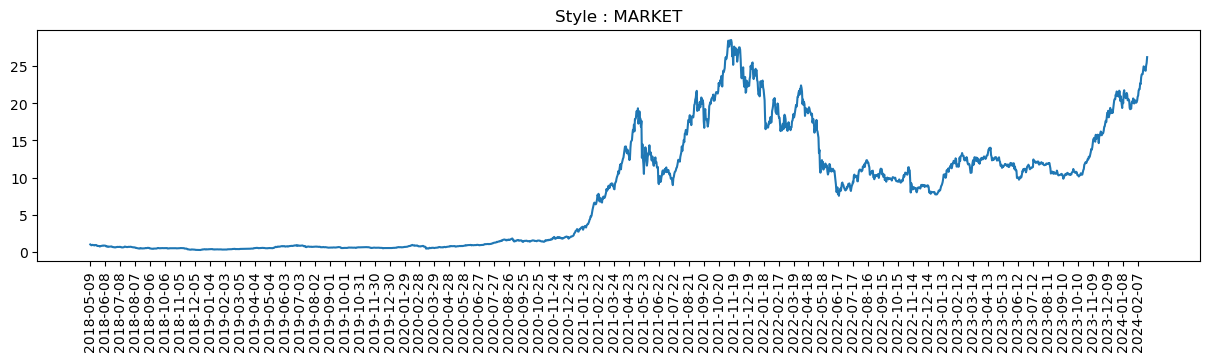

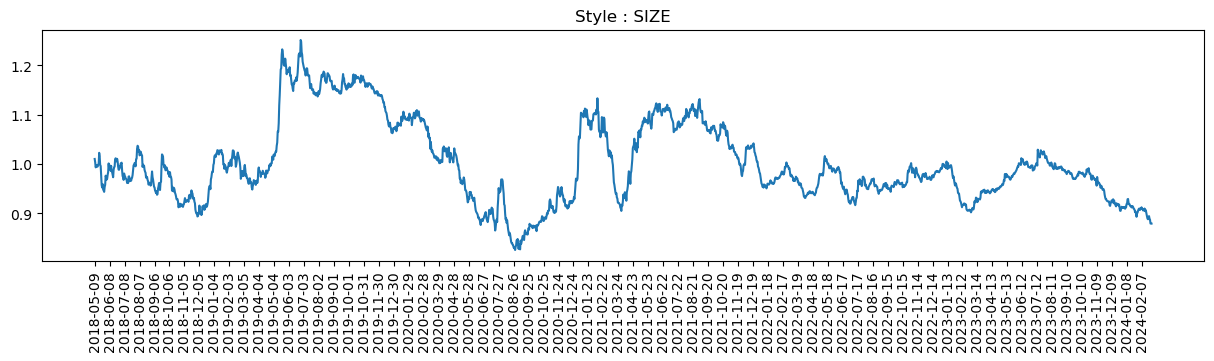

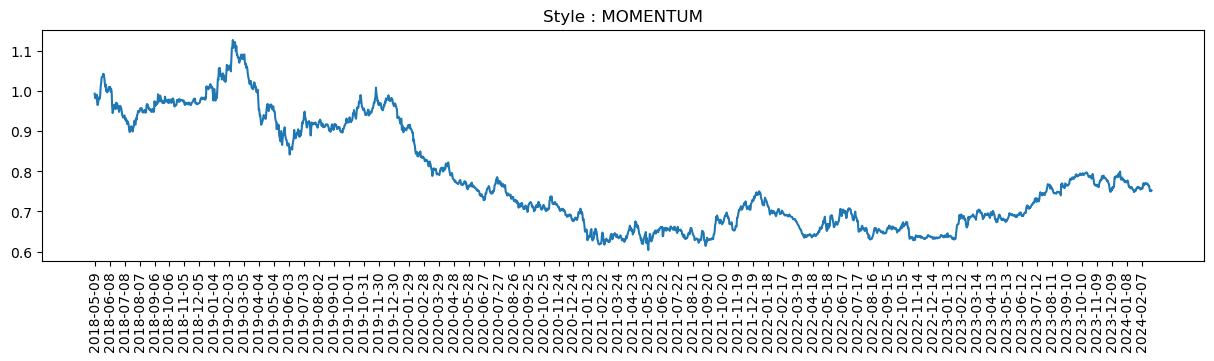

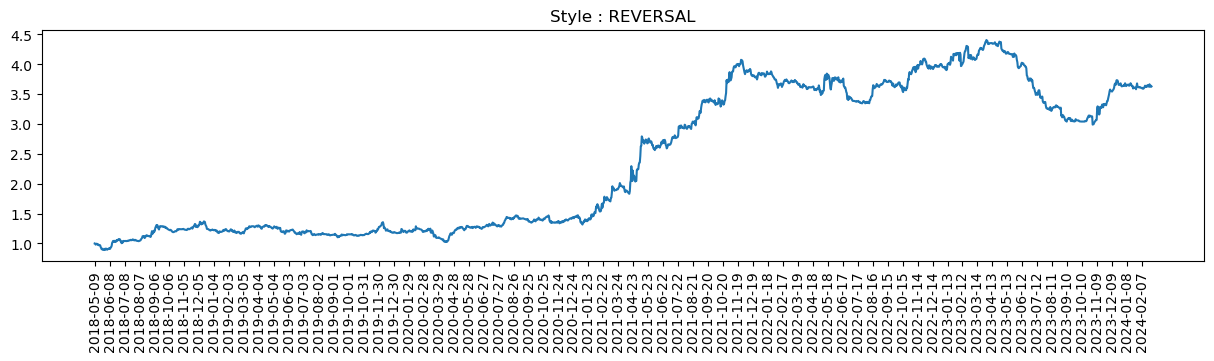

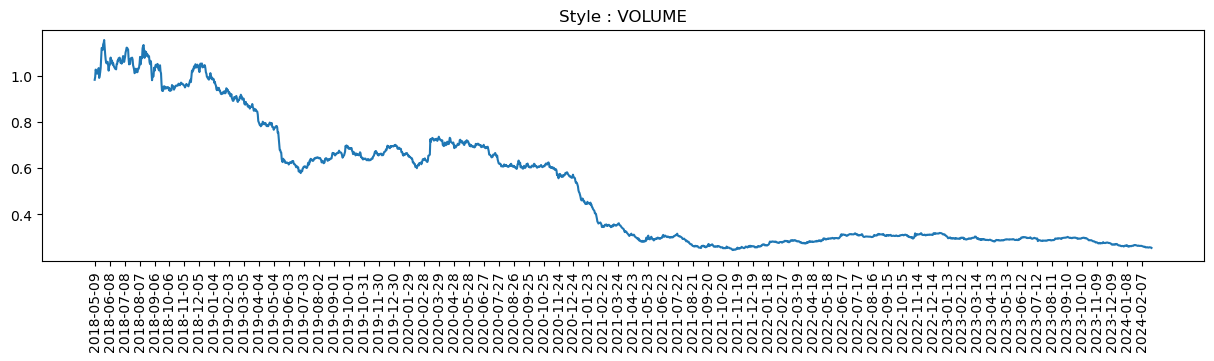

In [35]:
for style in parameters['REGRESSORS_SET1']:
    plt.figure(figsize=(15,3))
    plt.plot(range(0, len(all_coeff)),all_coeff[style+"_cumprod"])
    plt.title(f"Style : {style.upper()}")
    plt.xticks(range(0,len(all_coeff),30), list(all_coeff["date"])[::30], rotation = 90)
    plt.savefig(f"E:\Thesis\stuff\{style}.png")
    plt.show()

In [36]:
all_coeff[parameters['REGRESSORS_SET1']].corr()

,market,size,momentum,reversal,volume
market,1.000000,0.257951,0.062077,-0.050093,-0.841667
size,0.257951,1.000000,-0.053652,-0.018414,-0.538466
momentum,0.062077,-0.053652,1.000000,-0.260742,-0.021427
reversal,-0.050093,-0.018414,-0.260742,1.000000,0.028644
volume,-0.841667,-0.538466,-0.021427,0.028644,1.000000


In [ ]:
estimation_basis["weight"] = estimation_basis["transformed_market_cap"] / sum(estimation_basis[estimation_basis["core_universe"]>0]["transformed_market_cap"])

In [ ]:
estimation_basis[estimation_basis["core_universe"]>0].head(15)

,ticker,market_cap,transformed_market_cap,new_coin,core_universe,weight
0,BTC-USD,1004268748800,1.002132e+06,0.000000,1,0.119426
0,ETH-USD,355934994432,5.966029e+05,0.000000,1,0.071099
0,USDT-USD,97899159552,3.128884e+05,0.000000,1,0.037288
0,BNB-USD,57054277632,2.388604e+05,0.000000,1,0.028466
0,SOL-USD,45141934080,2.124663e+05,0.000000,1,0.025320
0,XRP-USD,29754994688,1.724964e+05,0.000000,1,0.020557
0,STETH-USD,28968859648,1.702024e+05,0.000000,1,0.020283
0,USDC-USD,28143104000,1.677591e+05,0.000000,1,0.019992
0,ADA-USD,21002196992,1.449213e+05,0.000000,1,0.017271
0,AVAX-USD,13779823616,1.173875e+05,0.000000,1,0.013989


In [6]:
refresh_raw_price_database(price_data_map, DATABASE_LOCATION)

In [7]:
with sqlite3.connect(os.path.join(DATABASE_LOCATION, "raw_price_data.db")) as conn:
    df = pd.read_sql_query("SELECT * FROM raw_price_data", conn)


In [8]:
display(df.head())

,open,high,low,close,volume,dividends,stock_splits,date,symbol
0,0.000663,0.000757,0.000306,0.000318,159482,0.0,0.0,2023-01-31,0X0-USD
1,0.000317,0.000536,0.000275,0.000412,107398,0.0,0.0,2023-02-01,0X0-USD
2,0.000412,0.000847,0.000372,0.000735,193915,0.0,0.0,2023-02-02,0X0-USD
3,0.000735,0.000915,0.000391,0.000517,96334,0.0,0.0,2023-02-03,0X0-USD
4,0.000517,0.000611,0.000396,0.000418,46436,0.0,0.0,2023-02-04,0X0-USD
